In [1]:
# download PyTorch with CUDA support and other binaries 

!pip3 install http://download.pytorch.org/whl/cu91/torch-0.3.1-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

    100% |████████████████████████████████| 531.3MB 10.9MB/s 
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 61kB 1.7MB/s 
    100% |████████████████████████████████| 2.0MB 548kB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# import NLTK and relevant packages

import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /content/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /content/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
# import relevant libraries

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
import sys
import random
import string
import matplotlib.pyplot as plt
import scipy.io as sio
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

In [0]:
# using Google Colab in Google Drive -- instructions taken from https://www.kdnuggets.com/2018/02/google-colab-free-gpu-tutorial-tensorflow-keras-pytorch.html

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0


Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting

In [5]:
# mounting Google Drive - instructions taken from https://www.kdnuggets.com/2018/02/google-colab-free-gpu-tutorial-tensorflow-keras-pytorch.html

!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
"""
Get pre-trained word embeddings calculated using the GloVe algorithm.

"""

def get_word_embeddings(glove_file):
    
    # create word embeddings using GloVe
    with open(glove_file, 'r') as file:
        word_embeddings = {}
        
        for line in file:
            line = line.strip().split()
            word = line[0]
            word_embeddings[word] = np.array(line[1:], dtype=np.float64)
    
    # get dimensions
    if '.100d.' in glove_file:
        feature_dims = 100
    elif '.50d.' in glove_file:
        feature_dims = 50
    
    return word_embeddings, feature_dims

In [0]:
"""
Define LSTM architecture

"""

class LSTM(nn.Module):
    
    # initialize architecture
    def __init__(self, word_embeddings, feature_dims, hidden_dims, num_recurrent_layers, batch_size, label_size, use_gpu):
        
        # sequential layer --> unidirectional LSTM-RNN layer --> fully connected last layer output x 32 --> 32 x labelsize --> softmax --> probability estimates
        
        super(LSTM, self).__init__()
        self.word_embeddings = word_embeddings
        self.hidden_dims = hidden_dims
        self.num_recurrent_layers = num_recurrent_layers
        self.batch_size = batch_size
        self.use_gpu = use_gpu
        self.lstm = nn.LSTM(input_size=feature_dims, hidden_size=hidden_dims, num_layers=num_recurrent_layers)
        self.hidden_to_fc1 = nn.Linear(hidden_dims, 32)
        self.fc1_to_label = nn.Linear(32, label_size)
        self.hidden = self.init_hidden()
    
    # initialize hidden and memory units
    def init_hidden(self):
        
        if self.use_gpu and torch.cuda.is_available():
            return (Variable(torch.zeros(self.num_recurrent_layers, self.batch_size, self.hidden_dims)).cuda(), Variable(torch.zeros(self.num_recurrent_layers, self.batch_size, self.hidden_dims)).cuda())
        else:
            return (Variable(torch.zeros(self.num_recurrent_layers, self.batch_size, self.hidden_dims)), Variable(torch.zeros(self.num_recurrent_layers, self.batch_size, self.hidden_dims)))

    
    # forward pass
    def forward(self, article_batch):
        
        article_batch_tensor = torch.FloatTensor(article_batch)
        x = Variable(article_batch_tensor)
        if self.use_gpu and torch.cuda.is_available():
            x = x.cuda()
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_fc1 = self.hidden_to_fc1(lstm_out[-1])
        y = self.fc1_to_label(y_fc1)
        label = F.softmax(y, dim = 1)
        return label

In [0]:
torch.manual_seed(42)

"""
Get word embeddings and feature dimensions

"""

word_embeddings, feature_dims = get_word_embeddings('drive/CIS520Project/glove.6B.100d.txt')

"""
Get data

"""

data_file = 'drive/CIS520Project/labeled_data_bin.json'

with open(data_file, 'r') as f:
    
    labeled_data = json.load(f)

# get articles and corresponding labels    
data = []
for article in labeled_data:
    
    data.append((article['article'], int(article['label'])))               

# shuffle data    
random.shuffle(data)


 Removing stop-words and proper nouns; performing stemming and lemmatization; removing duplicates 



<Container object of 836 artists>

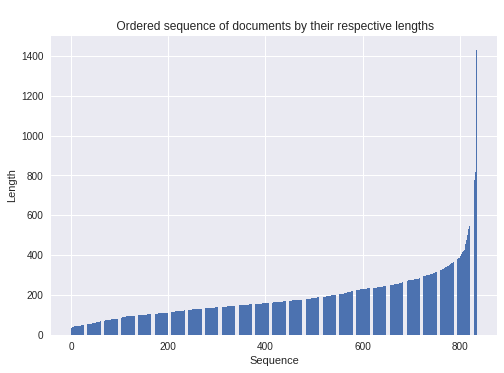

In [9]:
"""
Clean train and test data

"""

# get stop words

stop_words = set(nltk.corpus.stopwords.words('english'))

# remove stop words, punctuations, perform stemming and lemmatization

wordnetlem = WordNetLemmatizer()
lancstem = LancasterStemmer()
data_cleaned = []

print("\n Removing stop-words and proper nouns; performing stemming and lemmatization; removing duplicates \n")

for i, item in enumerate(data):
    
    article, label = item
    
    # replacing links with 'URL'
    mod_article = re.sub(r'http\S+', "URL", article)
    
    # get tokens
    tokens = nltk.word_tokenize(mod_article)
    
    # get POS tags
    pos_tags = nltk.pos_tag(tokens)
    
    # remove proper nouns and URLs
    filt = []
    for item in pos_tags:
        token, pos = item
        if pos != 'NNP':
           filt.append(token.lower())
    
    # remove stop words
    filt1 = [t for t in filt if not t in stop_words]
    
    # remove punctuation
    filt2 = [t for t in filt1 if not t in string.punctuation]
    
    # lemmatization
    filt3 = [wordnetlem.lemmatize(t) for t in filt2]
    
    # stemming
    filt4 = [lancstem.stem(t) for t in filt3]
    
    # remove repetitions
    filt5 = []
    for t in filt4:
        if t not in filt5:
            filt5.append(t)
            
    # get cleaned data        
    data_cleaned.append((filt5, label))

# sort the data by article lengths    
data_cleaned.sort(key = lambda x: len(x[0]))

# plot sorted article length vs article sequence
data_sizeL = []
for i in data_cleaned:
    a, l = i
    data_sizeL.append(len(a))

plt.title("\n Ordered sequence of documents by their respective lengths")
plt.xlabel("Sequence")
plt.ylabel("Length")
plt.bar(range(len(data_sizeL)),data_sizeL)

In [0]:
"""
Create training and test sets

"""

data_sub = data_cleaned[100:800]
random.shuffle(data_sub)

train_set = data_sub[:550]
test_set = data_sub[550:]

train_set.sort(key = lambda x: len(x[0]))
test_set.sort(key = lambda x: len(x[0]))
    
"""
Create X_train, y_train and X_test, y_test

"""

X_train = []
y_train= []
for item in train_set:
    
    tokens, label = item
    
    X = []
    for token in tokens:
        # if token not in vocabulary, replace it with "unknown" token
        if token not in word_embeddings.keys():
            X.append(word_embeddings["unk"])
        else:
            X.append(word_embeddings[token])
           
    X_train.append(X)
    y_train.append(label)

X_test = []
y_test = []
for item in test_set:
    
    tokens, label = item
    
    X = []
    for token in tokens:
        
        # if token not in vocabulary, replace it with "unknown" token and get its embedding vector; else simply get its embedding vector
        
        if token not in word_embeddings.keys():
            X.append(word_embeddings["unk"])
        else:
            X.append(word_embeddings[token])
        
    X_test.append(X)
    y_test.append(label)

In [0]:
! mkdir -p drive/CIS520Project/BATCH100d

# export train and test data to json files for future use

train_set_dict = [{"article":i[0], "label":i[1]} for i in train_set]
with open("drive/CIS520Project/BATCH100d/train_set.json", "w") as f:
    json.dump(train_set_dict, f)

test_set_dict = [{"article":i[0], "label":i[1]} for i in test_set]
with open("drive/CIS520Project/BATCH100d/test_set.json", "w") as f:
    json.dump(test_set_dict, f)    


# export train and test data to mat files for use in MATLAB R2018 implementation

sio.savemat('drive/CIS520Project/BATCH100d/X_train.mat', {'X_train':X_train})
sio.savemat('drive/CIS520Project/BATCH100d/y_train.mat', {'y_train':y_train})
sio.savemat('drive/CIS520Project/BATCH100d/X_test.mat', {'X_test':X_test})
sio.savemat('drive/CIS520Project/BATCH100d/y_test.mat', {'y_test':y_test})

In [0]:
"""
Create mini-batches

"""

def get_mini_batches(X_train, y_train, X_test, y_test):
    
    # specify mini-batch size for train and test sets
    
    batch_size = 50

    # create train mini-batch

    X_train1_batch_list_tmp = []
    y_train1_batch_list = []

    for i in range(0, len(X_train), batch_size):
        
        X_train1_batch_list_tmp.append(X_train[i:i+batch_size])
    
    for j in range(0, len(y_train), batch_size):
  
        y_train1_batch_list.append(y_train[j:j+batch_size])
    
    X_train1_batch_list = []
    
    # get padded train mini-batches
    
    for batch in X_train1_batch_list_tmp:
  
        maxlength = 0
        for i in batch:
            if len(i) >= maxlength:
                maxlength = len(i)
            else:
                maxlength = maxlength
    
        for i in batch:
            diff = maxlength - len(i)
            for j in range(diff):
                i.append(np.arange(len(i[0]))*0)
            
        X_train1_batch_list.append(np.transpose(np.array(batch), (1, 0, 2)))
    
    train1_batch_list = list(zip(X_train1_batch_list, y_train1_batch_list))

    # create test mini-batch

    X_test1_batch_list_tmp = []
    y_test1_batch_list = []

    for i in range(0, len(X_test), batch_size):
    
        X_test1_batch_list_tmp.append(X_test[i:i+batch_size])
    
    for j in range(0, len(y_test), batch_size):
  
        y_test1_batch_list.append(y_test[j:j+batch_size])
    
    X_test1_batch_list = []
  
    # get padded test mini-batches
    
    for batch in X_test1_batch_list_tmp:
  
        maxlength = 0
        for i in batch:
            if len(i) >= maxlength:
                maxlength = len(i)
            else:
                maxlength = maxlength  
    
        for i in batch:
            diff = maxlength - len(i)
            for j in range(diff):
                i.append(np.arange(len(i[0]))*0)
            
        X_test1_batch_list.append(np.transpose(np.array(batch), (1, 0, 2)))
    
    test1_batch_list = list(zip(X_test1_batch_list, y_test1_batch_list))
    
    return train1_batch_list, test1_batch_list, batch_size

In [70]:
# get the mini-batches

train_batch_list, test_batch_list, BATCH_SIZE = get_mini_batches(X_train, y_train, X_test, y_test)


"""
Train the model

"""

# specify parameters
HIDDEN_DIMS = 48
NUM_RECURRENT_LAYERS = 1
LABEL_SIZE = 2

# specify whether to use GPU
use_gpu = True

if use_gpu and torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# get the LSTM model
lstm_model = LSTM(word_embeddings, feature_dims, HIDDEN_DIMS, NUM_RECURRENT_LAYERS, BATCH_SIZE, LABEL_SIZE, use_gpu)

if use_gpu and torch.cuda.is_available():
    lstm_model.cuda()

# specify loss function
loss_function = nn.CrossEntropyLoss()

# specify optimizer for learning weights
optimizer = optim.Adam(lstm_model.parameters(), lr = 1e-3)

# specify max epochs
MAX_EPOCHS = 50

loss_list = []
accuracy_list = []

random.shuffle(train_batch_list)

print("\n Training the LSTM network...")

for epoch in range(1, MAX_EPOCHS + 1):
    
    avg_train_loss = 0.0
    
    truth = []
    prediction = []
    
    for batch in train_batch_list:
        
        article_batch, label_batch = batch
        
        true_label = []
        
        for label in label_batch:
          
            if label == -1:
              mod_label = 0
              true_label.append(mod_label) 
            elif label == 1:
              mod_label = 1
              true_label.append(mod_label)
        
        truth += [i for i in true_label]
        
        true_label = Variable(torch.LongTensor(true_label))
        
        if use_gpu and torch.cuda.is_available():
            true_label = true_label.cuda() 
        
        # reset gradients to zero
        lstm_model.zero_grad()
        
        # initialize hidden features
        lstm_model.hidden = lstm_model.init_hidden()
        
        # make predictions
        pred = lstm_model(article_batch)
        
        predicted_label = pred.data.max(1)[1].cpu().numpy()
    
        prediction += [i for i in predicted_label]
        
        # calculate the loss
        loss = loss_function(pred, true_label)
        avg_train_loss += loss.data.cpu().numpy()[0]
        
        # backpropagation-thorugh-time (BPT)
        loss.backward()
        
        # update weights
        optimizer.step()
    
    avg_training_loss = float(avg_train_loss)/float(len(train_batch_list))
    
    loss_list.append(avg_training_loss)
    
    # calculate the accuracy
    
    right = 0
    
    for i in range(len(truth)):
    
        if prediction[i] == truth[i]:
        
            right += 1
        
    accuracy = float(right)/float(len(truth))
    
    accuracy_list.append(accuracy)
    
    if epoch % 10 == 0:
        
        print ("\n" + str(epoch) + " epochs completed")       


 Training the LSTM network...

10 epochs completed

20 epochs completed

30 epochs completed

40 epochs completed

50 epochs completed


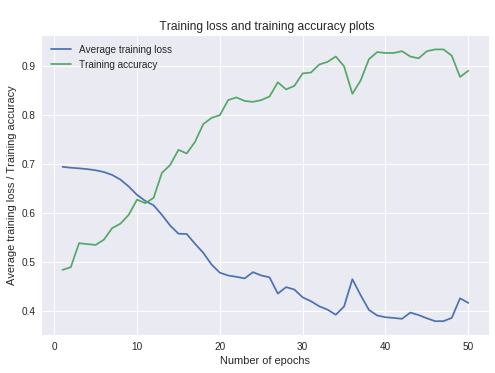

In [71]:
plt.title("\n Training loss and training accuracy plots")
plt.xlabel("Number of epochs")
plt.ylabel("Average training loss / Training accuracy")
plt.plot(range(1, MAX_EPOCHS + 1), loss_list, range(1, MAX_EPOCHS + 1), accuracy_list)
plt.legend(['Average training loss', 'Training accuracy'])

In [72]:
"""
Test the accuracy of the model

"""

avg_test_loss = 0.0
prediction = []
truth = []

print("\n Testing the LSTM network...")

random.shuffle(test_batch_list)

for batch in test_batch_list:
  
    article_batch, label_batch = batch
        
    true_label = []
    
    for label in label_batch:
        
        if label == -1:
            mod_label = 0
            true_label.append(mod_label) 
        elif label == 1:
            mod_label = 1
            true_label.append(mod_label)
        
    truth += [i for i in true_label]
    
    true_label = Variable(torch.LongTensor(true_label)) 
    
    # initialize hidden features
    lstm_model.hidden = lstm_model.init_hidden()
    
    # make predictions
    pred = lstm_model(article_batch)
        
    predicted_label = pred.data.max(1)[1].cpu().numpy()
    
    prediction += [i for i in predicted_label]
    
    # calculate the loss
    loss = loss_function(pred, true_label)
        
    avg_test_loss += loss.data.cpu().numpy()[0]

avg_testing_loss = float(avg_test_loss)/float(len(test_batch_list))

print("\n Average test loss : " + str(avg_testing_loss))

# calculate the accuracy

right = 0

for i in range(len(truth)):
    
    if prediction[i] == truth[i]:
        
        right += 1
        
accuracy = float(right)/float(len(truth))

print("\n Accuracy : " + str(accuracy*100) + " %")


 Testing the LSTM network...

 Average test loss : 0.7481874823570251

 Accuracy : 41.333333333333336 %


In [0]:
# clear variables to free memory

del lstm_model
del loss_function
del optimizer